# 2-1. 들어가며

### 실습목표
---
1. 직접 ResNet 구현하기
2. 모델을 config에 따라서 변경가능하도록 만들기
3. 직접 실험해서 성능 비교하기


### 학습내용
---
1. Ablation Study
2. Back to the 2015
3. Block
4. Complete Model
5. Experiment

$ pip install tensorflow-datasets

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

CIFAR-10은 대용량 데이터셋은 아니지만 그래도 로드되는 데 꽤 긴 시간이 걸립니다. 잠깐 커피를 드시면서 숨을 돌리셔도 좋습니다.

데이터셋이 준비되면 클래스의 수와 클래스에 따른 이름을 볼 수 있습니다. **DatasetBuilder**의 **info**를 통해 정보를 확인해 보세요.

>❗️ tfds.load()는 기본적으로 ~/tensorflow_datasets 경로에 데이터셋을 다운로드합니다. 데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이므로, ~/aiffel 프로젝트 폴더가 아닌 기본 경로에 다운 받아 사용하시면 됩니다. 혹시 데이터셋 경로를 바꾸고 싶으시다면, data_dir 인자를 사용하세요.

In [3]:
import urllib3
urllib3.disable_warnings()

dataset_name = 'cats_vs_dogs'
ds_train, ds_info_train = tfds.load(name=dataset_name, split='train[:80%]', as_supervised=True, with_info=True)
ds_valid, ds_info_valid = tfds.load(name=dataset_name, split='train[80%:]', as_supervised=True, with_info=True)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info_train.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


Tensorflow의 데이터셋은 Numpy가 아니므로 **ds_train.shape** 같은 게 존재하지 않습니다. 위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 갯수, 라벨 클래스의 갯수 등 가장 중요한 정보들이 잘 확인되었나요?

### 2) Input Normalization
---
- [딥러닝 용어 정리, Normalization(정규화) 설명](https://light-tree.tistory.com/132)

우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있는데요. 이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현합니다. RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법이죠. 그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지입니다. RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있습니다.

우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 **정규화(normalize)**를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 2-7. 프로젝트: ResNet Ablation Study
### 1) ResNet 기본 블록 구성하기
---
이제 실전으로 돌아와서 **ResNet-34**와 **ResNet-50** 네트워크를 직접 만든다고 생각해봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

[Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)

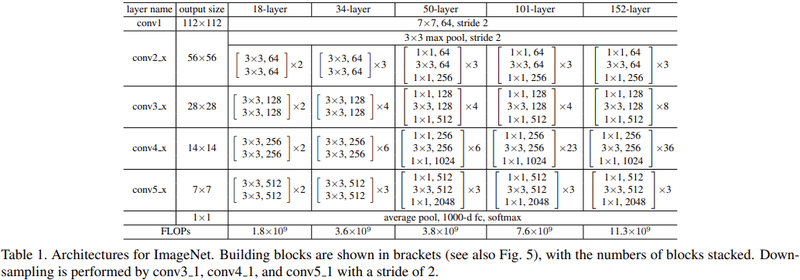

> **Q1. ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.**

> ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 
그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. Learning by Doing 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.

우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇번의 경험이 있습니다.
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.

그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.

하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.

### 2) ResNet-34, ResNet-50 Complete Model
---
#### ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 `build_resnet()`를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,


***

# 여기부터 프로젝트 시작

### 첫 번째 공통 레이어: 7*7 conv2d -> BN -> Relu -> MaxPooling

In [7]:
# 첫 번째 공통 레이어: 7*7 conv2d -> BN -> Relu -> MaxPooling
def conv1(x): 
    # Conv2D
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2,2),
        kernel_initializer='he_normal',
        padding='same', name='conv2d_7x7'
    )(x)

    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization()(x)

    # Activation
    x = tf.keras.layers.Activation('relu')(x)

    # maxpooling
    x = keras.layers.MaxPooling2D(
             pool_size=(2, 2),
             strides=2,
             name='stage2_0_maxpooling'
            )(x)
    
    return x

### Residual 통과(layer-18,34): 1\*1 conv2d stride2 -> BN

In [8]:
# residual 통과(layer-18,34): 1*1 conv2d stride2 -> BN
def conv_short(x,filters,stage_num,block_num):
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=(1,1),
        kernel_initializer='he_normal',
        padding='same', strides=(2,2),
        name=f'stage{stage_num}_{block_num+1}_short'
    )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization()(x)
    
    return x

### Residual 통과(layer-50,101,152): 1\*1 conv2d stride1 -> BN

In [9]:
# residual 통과(layer-50,101,152): 1*1 conv2d stride1 -> BN
def conv_short50(x,filters, stage_num, block_num):
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=(1,1),
        kernel_initializer='he_normal',
        padding='same', strides=(1,1), 
        name=f'stage{stage_num}_{block_num+1}_short'
    )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn4')(x)
    
    return x

### conv2_x 생성 함수

In [10]:
# conv2_x 블럭

def conv_master1(x,
                 first_layer,
                 block_num,
                 kernel_size,
                 filters,
                 stage_num,
                 num_layer=34,
                 is_plain=False
                 ):
    """
    conv2
    1) layer-18: [[3*3],64, [3*3],64]*2
    2) layer-34: [[3*3],64, [3*3],64]*3
    3) layer-50: [[1*1],64, [3*3],64, [1*1],256]
    """
    
    # residual 정의
    residual = x
    
    if num_layer == 18 or num_layer == 34:
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv2'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)
        
        if not is_plain:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])

        # activation
        x = tf.keras.layers.Activation('relu')(x)
        
    else:
        # 3개 층 중에서 첫번째 층만 shortcut이고 나머지 두 개는 입력값을 그대로 사용
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size[0],
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
        
        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size[1],
            kernel_initializer='he_normal', name=f'stage{stage_num}_{block_num+1}_conv2',
            padding='same'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters*4, # 마지막 레이어는 4배이다.
            kernel_size=kernel_size[2],
            kernel_initializer='he_normal', name=f'stage{stage_num}_{block_num+1}_conv3',
            padding='same'
        )(x)
        
        # short
        conv3_short = conv_short50(residual, filters=filters*4, stage_num=stage_num, block_num=block_num)
        
        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn3')(x)
        
        if not is_plain:
            if first_layer:
                # add
                x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, conv3_short])
            else:
                # add
                x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])
            
        # activation
        x = tf.keras.layers.Activation('relu')(x)
        
    return x

### conv3_x ~ conv5_x 블럭 생성할 수 있는 함수

In [11]:
# conv3_x ~ conv5_x 블럭
def conv_master2(x,
                 block_num,
                 kernel_size,
                 filters,
                 first_layer, # True/False,
                 stage_num,
                 num_layer=34,
                 is_plain=False
                 ):
    
    residual = x
    
    # kernel_size_copy
    if num_layer == 50 or num_layer == 101 or num_layer == 152:
        kernel_size_copy = kernel_size.copy()
        kernel_size = kernel_size_copy[0]
        
    # <!-- first block --!>    
    # 첫 번재 층은 stride를 해야 함.
    if first_layer:
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', strides=(2,2), # stride
            name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
    
    else:
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

    # Activation
    x = tf.keras.layers.Activation('relu')(x)

    if num_layer==50 or num_layer==101 or num_layer==152: 
        # <!-- second block --!>
        kernel_size = kernel_size_copy[1]
#         print(f'stage{stage_num}_{block_num+1}_conv2')
#         print('kernel_size: ', kernel_size)
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',name=f'stage{stage_num}_{block_num+1}_conv2',
            padding='same'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)
    
    
    # <!-- third block --!>
#     print(f'stage{stage_num}_{block_num+1}_conv2')
#     print('kernel_size: ', kernel_size)
    conv_num=3
    if num_layer==50 or num_layer==101 or num_layer==152:
        filters=filters*4
        kernel_size = kernel_size_copy[2]
    else: conv_num-=1
    
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',name=f'stage{stage_num}_{block_num+1}_conv{conv_num}',
        padding='same'
    )(x)

    # short
    conv3_short = conv_short(residual, filters, stage_num=stage_num, block_num=block_num)
    conv3_short50 = conv_short50(residual, filters, stage_num=stage_num, block_num=block_num)

    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn{conv_num}')(x)
    
    if not is_plain:
        if first_layer:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, conv3_short])
        else:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])

    # activation
    x = tf.keras.layers.Activation('relu')(x)

    return x

### ResNet 생성 함수

In [12]:
# function for building ResNet Block

def build_resnet(input_layer, num_layer=34, is_residual=True, is_plain=False):
    
    # layer개수에 따른 cnn층 개수
    cnn_layer ={
                18 : [2,2,2,2], 
                34 : [3,4,6,3], 
                50 : [3,4,6,3], 
                101 : [3,4,23,3],
                152 : [3,8,36,3]
                }
    
    # layer개수에 따른 filter 리스트
    filter_list = [64, 128, 256, 512]
    
    # layer별 커널 사이즈
    kernel_size_dict = {18:(3,3),
                   34:(3,3),
                   50:[(1,1),(3,3),(1,1)],
                   101:[(1,1),(3,3),(1,1)],
                   152:[(1,1),(3,3),(1,1)]}
    
    # layer별 커널 사이즈
    kernel_size = kernel_size_dict[num_layer]
    
    # cnn층 블록 개수 리스트(num_cnn_list) 할당
    num_cnn_list = cnn_layer[num_layer]
    
    # 전체 conv 블록 개수
    num_conv = len(num_cnn_list)
    
    # 입력 레이어
    x = input_layer
    
    # 7*7, 64, stride2 + maxpooling
    x = conv1(x)
    
    # stage num 정의
    stage_num = 2
    
    # conv_idx 정의
    conv_idx=0

    # conv2_x
    
    # layer-50,101,152만 해당
    first_layer = [True,False,False]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master1(x,
                         first_layer=first_layer[i],
                         block_num=i,
                         kernel_size=kernel_size,
                         filters=filter_list[conv_idx],
                         stage_num=stage_num,
                         num_layer=num_layer,
                         is_plain=is_plain
                         )
#     print('conv2 완료')

    # conv3_x
    stage_num+=1
    conv_idx+=1
    if is_residual: # residual 있을때
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:          # residual 없을때
        first_layer = [False]*num_cnn_list[conv_idx]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
        
#     print('conv3 완료')

    # conv4_x
    stage_num+=1
    conv_idx+=1
    
    if is_residual:
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:
        first_layer = [False]*num_cnn_list[conv_idx]
#     print('first_layer: ',first_layer)
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
#     print('conv4 완료')
    # conv5_x
    stage_num+=1
    conv_idx+=1
    
    if is_residual:
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:
        first_layer = [False]*num_cnn_list[conv_idx]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
#     print('conv5 완료')

    # avg pooling
    x= keras.layers.AveragePooling2D(
        pool_size=(2, 2), strides=2, padding='SAME', name='avg_pool')(x)
    
    # flatten
    x = keras.layers.Flatten(name='flatten_11')(x)
    
    # FC layer(2) --- 우리가 사용할 데이터는 '고양이', '개' 두 가지 클래스만 있으므로 이걸 사용해야함.
    x = keras.layers.Dense(2,name='fc2')(x)
    
    # FC layer(10) --- 노드의 파라미터 확인용(cifar-10일 때는 이것을 사용해야함) 확인이 끝난 후에는 다시 주석 처리했음.
#     x = keras.layers.Dense(10,name='fc2')(x)
    
    return x

***
## 입력 크기 (32,32,3)을 이용해 summary를 통해 모델이 잘 만들어졌는지 확인
### 1) resnet 34 확인 결과: 일치  
- 생성 파라미터 개수 일치!  

**Total params: 21,315,338  
Trainable params: 21,298,314  
Non-trainable params: 17,024**

In [ ]:
# 모델 확인: resnet34 with input (32,32,3)

resnet34_input_layer_ex = keras.layers.Input(shape=(32,32,3), name='input_layer')   # 입력 레이어 생성
resnet34_block_output_ex = build_resnet(resnet34_input_layer_ex)

resnet34_ex = keras.Model(inputs=resnet34_input_layer_ex, outputs=resnet34_block_output_ex)
resnet34_ex.summary()

### 2) resnet 50 확인 결과: 일치  
- 생성 파라미터 개수 일치!  

**Total params: 23,608,202  
Trainable params: 23,555,082  
Non-trainable params: 53,120**

In [ ]:
# 모델 확인: resnet50 with input (32,32,3)

resnet50_input_layer_ex = keras.layers.Input(shape=(32,32,3), name='input_layer')   # 입력 레이어 생성
resnet50_block_output_ex = build_resnet(resnet50_input_layer_ex, num_layer=50)

resnet50_ex = keras.Model(inputs=resnet50_input_layer_ex, outputs=resnet50_block_output_ex)
resnet50_ex.summary()

## 🌟번외: ResNet-18,101,152도 잘 만들어질까?
- 논문에서는 총 다섯 종류가 있어서 하나의 함수로 구현될 수 있도록 만들었음. 실제로 만들어지는지 확인.  

1. ResNet-18

In [ ]:
# 모델 확인: resnet18 with input (32,32,3)

resnet18_input_layer_ex = keras.layers.Input(shape=(32,32,3), name='input_layer')   # 입력 레이어 생성
resnet18_block_output_ex = build_resnet(resnet18_input_layer_ex, num_layer=18) # num_layer를 입력하면 생성된다.

resnet18_ex = keras.Model(inputs=resnet18_input_layer_ex, outputs=resnet18_block_output_ex)
resnet18_ex.summary()

2. ResNet-101

In [ ]:
# 모델 확인: resnet101 with input (32,32,3)

resnet101_input_layer_ex = keras.layers.Input(shape=(32,32,3), name='input_layer')   # 입력 레이어 생성
resnet101_block_output_ex = build_resnet(resnet101_input_layer_ex, num_layer=101) # num_layer를 입력하면 생성된다.

resnet101_ex = keras.Model(inputs=resnet101_input_layer_ex, outputs=resnet101_block_output_ex)
resnet101_ex.summary()

3. ResNet-152

In [ ]:
# 모델 확인: resnet152 with input (32,32,3)

resnet152_input_layer_ex = keras.layers.Input(shape=(32,32,3), name='input_layer')   # 입력 레이어 생성
resnet152_block_output_ex = build_resnet(resnet152_input_layer_ex, num_layer=152) # num_layer를 입력하면 생성된다.

resnet152_ex = keras.Model(inputs=resnet152_input_layer_ex, outputs=resnet152_block_output_ex)
resnet152_ex.summary()

***

### 데이터 정의 및 하이퍼 파라미터 정의

In [13]:
BATCH_SIZE = 16
EPOCH = 20

# 데이터 정의
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_valid = apply_normalize_on_dataset(ds_valid, batch_size=BATCH_SIZE)

## 1. ResNet-34 VS Plain-34
### 1) Plain-34
**실행하기 전 `bulid_resnet`함수 마지막 Dense를 변경(10->2)**

In [14]:
plain34_input_layer = keras.layers.Input(shape=(224,224,3), name='input_layer')   # 입력 레이어 생성 = (224,224,3)
plain34_block_output = build_resnet(plain34_input_layer, is_plain=True) # is_plain=True 설정


plain34 = keras.Model(inputs=plain34_input_layer, outputs=plain34_block_output)
plain34.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_7x7 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256   

In [15]:
# Plain-34 학습
plain34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain34.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 110s 79ms/step - loss: 0.7245 - accuracy: 0.5181 - val_loss: 0.6930 - val_accuracy: 0.5121
Epoch 2/20
1163/1163 [==============================] - 104s 89ms/step - loss: 0.6931 - accuracy: 0.5262 - val_loss: 0.6928 - val_accuracy: 0.5127
Epoch 3/20
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6930 - accuracy: 0.5190 - val_loss: 0.6960 - val_accuracy: 0.5119
Epoch 4/20
1163/1163 [==============================] - 97s 83ms/step - loss: 0.6931 - accuracy: 0.5176 - val_loss: 0.6931 - val_accuracy: 0.5114
Epoch 5/20
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6955 - val_accuracy: 0.5132
Epoch 6/20
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6930 - accuracy: 0.5235 - val_loss: 0.6959 - val_accuracy: 0.5019
Epoch 7/20
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6931 - accuracy: 0.5151 - val_loss: 0.6931

### 2) ResNet-34

In [16]:
resnet34_input_layer = keras.layers.Input(shape=(224,224,3), name='input_layer')   # 입력 레이어 생성 = (224,224,3)
resnet34_block_output = build_resnet(resnet34_input_layer)


resnet34 = keras.Model(inputs=resnet34_input_layer, outputs=resnet34_block_output)
resnet34.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7x7 (Conv2D)             (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 112, 112, 64) 256         conv2d_7x7[0][0]                 
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [17]:
# ResNet-34 학습
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 105s 82ms/step - loss: 0.7930 - accuracy: 0.5267 - val_loss: 0.7063 - val_accuracy: 0.5407
Epoch 2/20
1163/1163 [==============================] - 101s 87ms/step - loss: 0.8947 - accuracy: 0.5370 - val_loss: 0.6930 - val_accuracy: 0.5516
Epoch 3/20
1163/1163 [==============================] - 95s 81ms/step - loss: 0.6931 - accuracy: 0.5459 - val_loss: 0.6960 - val_accuracy: 0.5537
Epoch 4/20
1163/1163 [==============================] - 95s 81ms/step - loss: 0.6931 - accuracy: 0.5434 - val_loss: 0.6960 - val_accuracy: 0.5533
Epoch 5/20
1163/1163 [==============================] - 95s 81ms/step - loss: 0.6931 - accuracy: 0.5406 - val_loss: 0.6960 - val_accuracy: 0.5511
Epoch 6/20
1163/1163 [==============================] - 95s 82ms/step - loss: 0.6931 - accuracy: 0.5395 - val_loss: 0.6962 - val_accuracy: 0.5502
Epoch 7/20
1163/1163 [==============================] - 96s 82ms/step - loss: 0.6931 - accuracy: 0.5392 - val_loss: 0.6960

### 3) Plain-50

In [18]:
plain50_input_layer = keras.layers.Input(shape=(224,224,3), name='input_layer')   # 입력 레이어 생성 = (224,224,3)
plain50_block_output = build_resnet(plain50_input_layer, num_layer=50, is_plain=True) # is_plain=True 설정

plain50 = keras.Model(inputs=plain50_input_layer, outputs=plain50_block_output)
plain50.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_7x7 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_28 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_66 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [19]:
plain50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain50.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 201s 140ms/step - loss: 0.7578 - accuracy: 0.5164 - val_loss: 0.6931 - val_accuracy: 0.5041
Epoch 2/20
1163/1163 [==============================] - 144s 124ms/step - loss: 0.6931 - accuracy: 0.5183 - val_loss: 0.6931 - val_accuracy: 0.5116
Epoch 3/20
1163/1163 [==============================] - 132s 114ms/step - loss: 0.6931 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.5185
Epoch 4/20
1163/1163 [==============================] - 133s 114ms/step - loss: 0.6931 - accuracy: 0.5247 - val_loss: 0.6931 - val_accuracy: 0.5149
Epoch 5/20
1163/1163 [==============================] - 133s 114ms/step - loss: 0.6931 - accuracy: 0.5186 - val_loss: 0.6931 - val_accuracy: 0.5261
Epoch 6/20
1163/1163 [==============================] - 133s 114ms/step - loss: 0.6931 - accuracy: 0.5213 - val_loss: 0.6985 - val_accuracy: 0.5205
Epoch 7/20
1163/1163 [==============================] - 133s 114ms/step - loss: 0.6931 - accuracy: 0.5187 - val_

### 4) ResNet-50

In [20]:
resnet50_input_layer = keras.layers.Input(shape=(224,224,3), name='input_layer')   # 입력 레이어 생성 = (224,224,3)
resnet50_block_output = build_resnet(resnet50_input_layer, num_layer=50) # num_layer 설정

resnet50 = keras.Model(inputs=resnet50_input_layer, outputs=resnet50_block_output)
resnet50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7x7 (Conv2D)             (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 112, 112, 64) 256         conv2d_7x7[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 112, 112, 64) 0           batch_normalization_42[0][0]     
____________________________________________________________________________________________

In [21]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
1163/1163 [==============================] - 172s 136ms/step - loss: 0.7099 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5203
Epoch 2/20
1163/1163 [==============================] - 163s 140ms/step - loss: 0.6931 - accuracy: 0.5138 - val_loss: 0.6931 - val_accuracy: 0.5267
Epoch 3/20
1163/1163 [==============================] - 158s 136ms/step - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6931 - val_accuracy: 0.5013
Epoch 4/20
1163/1163 [==============================] - 160s 138ms/step - loss: 0.6931 - accuracy: 0.5105 - val_loss: 0.6931 - val_accuracy: 0.5071
Epoch 5/20
1163/1163 [==============================] - 158s 136ms/step - loss: 0.6931 - accuracy: 0.5118 - val_loss: 0.6931 - val_accuracy: 0.5123
Epoch 6/20
1163/1163 [==============================] - 158s 136ms/step - loss: 0.6931 - accuracy: 0.5204 - val_loss: 0.6931 - val_accuracy: 0.5019
Epoch 7/20
1163/1163 [==============================] - 158s 136ms/step - loss: 0.6931 - accuracy: 0.5129 - val_

***

## 2. ResNet-34 VS Plain-34 시각화

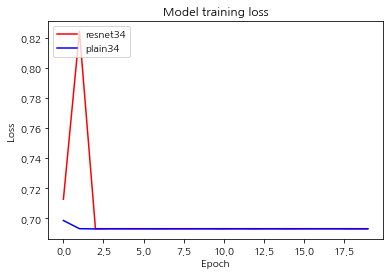

In [22]:
import matplotlib.pyplot as plt
# 학습 loss 시각화
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc='upper left')
plt.show()

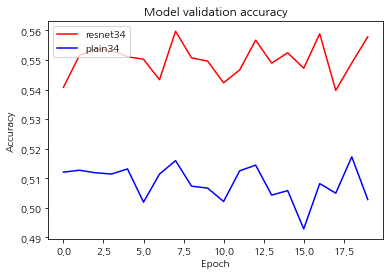

In [23]:
# 검증 Accuracy 시각화
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc='upper left')
plt.show()

## 3. ResNet-50 VS Plain-50 시각화

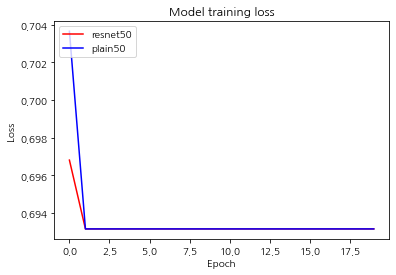

In [24]:
# 학습 loss 시각화
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc='upper left')
plt.show()

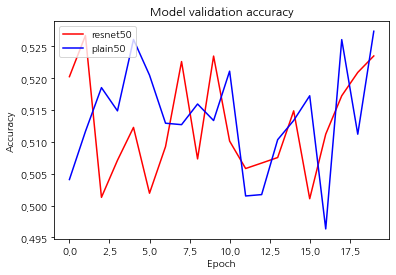

In [25]:
# 검증 Accuracy 시각화
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc='upper left')
plt.show()

## 4. ResNet-34 VS ResNet-50 시각화

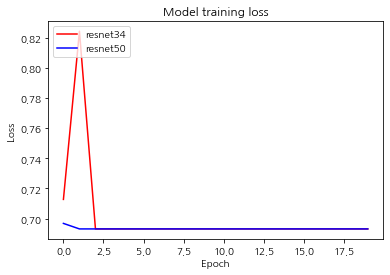

In [26]:
# 학습 loss 시각화
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50'], loc='upper left')
plt.show()

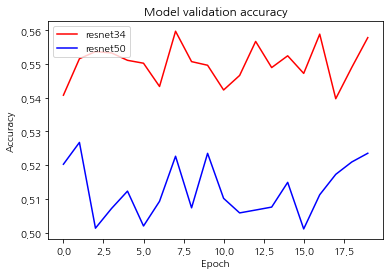

In [27]:
# 검증 Accuracy 시각화
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50'], loc='upper left')
plt.show()

## 5. 결과 정리

1. ResNet-34 VS Plain-34 비교: val acc의 경우 ResNet-34가 높았는데 특이하게 train loss는 동일했다.  
2. ResNet-50 Vs Plain-50 비교: 두 모델의 경우 큰 차이가 없어보였다.  
3. ResNet-34 VS ResNet-50 비교: val acc의 경우 ResNet-34가 높았는데 특이하게 train loss는 동일했다.  
4. ResNet의 5개 layer에 대해 모델 생성할 수 있는 함수 작성 성공.`num_layer`를 이용해 생성 가능.  
5. Plain 모델도 `is-plain`을 이용해 생성할 수 있다.  
6. 시각화 결과: 이상하게 train loss가 0.6931로 동일하게 나오는 모습을 확인했다.  

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---:|:---:|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|
